<a href="https://colab.research.google.com/github/rud-rax/nlp-p2.2/blob/Jakob/notebooks/2_bow_tfidf_vectorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2. BOW and TF-IDF Vectorization

This notebook implements the BoW and TF-IDF vectorization techniques with 12 different preprocessing configurations:
- With/without stop words
- With/without stemming
- Using unigrams, bigrams, or trigrams

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import re

# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

# Set up for displaying plots
%matplotlib inline
plt.style.use('ggplot')
sns.set(font_scale=1.2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Load Document Data

In [6]:
# Load documents from CSV
docs_df = pd.read_csv('drive/MyDrive/NLP 2_2/documents.csv')
document_texts = docs_df['text'].tolist()

# Load the original human similarity matrix for comparison later
human_similarity_matrix = np.load('drive/MyDrive/NLP 2_2/human_similarity_matrix.npy')

print(f"Loaded {len(document_texts)} documents")
print(f"Human similarity matrix shape: {human_similarity_matrix.shape}")

# Display a few document texts
for i, text in enumerate(document_texts[:5]):
    print(f"Document {i+1}: {text}")

Loaded 50 documents
Human similarity matrix shape: (50, 50)
Document 1: The cyber-attacker accessed your computer files.
Document 2: The cyber-attacker accessed your computer programs.
Document 3: The cyber-attacker accessed your information stored in an Internet site.
Document 4: The cyber-attacker caused a program on your computer to crash.
Document 5: The cyber-attacker caused your computer program to run very slowly.


## Preprocessing Functions

In [7]:
# Initialize stemmer and stopwords
stemmer = PorterStemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text, remove_stop_words=False, apply_stemming=False):
    """
    Preprocess text based on configuration.

    Args:
        text: The input text to preprocess
        remove_stop_words: Whether to remove stop words
        apply_stemming: Whether to apply stemming

    Returns:
        Preprocessed text
    """
    # Convert to lowercase and remove punctuation
    text = re.sub(r'[^\w\s]', '', text.lower())

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stop words if specified
    if remove_stop_words:
        tokens = [token for token in tokens if token not in stop_words]

    # Apply stemming if specified
    if apply_stemming:
        tokens = [stemmer.stem(token) for token in tokens]

    # Join tokens back into a string
    return ' '.join(tokens)

## Create Vectorizers for Different Configurations

In [8]:
def create_vectorizer(vectorizer_type, ngram_range=(1, 1)):
    """
    Create a vectorizer of the specified type with the given n-gram range.

    Args:
        vectorizer_type: 'bow' or 'tfidf'
        ngram_range: Tuple specifying the n-gram range

    Returns:
        A CountVectorizer or TfidfVectorizer
    """
    if vectorizer_type == 'bow':
        return CountVectorizer(ngram_range=ngram_range)
    elif vectorizer_type == 'tfidf':
        return TfidfVectorizer(ngram_range=ngram_range)
    else:
        raise ValueError(f"Unknown vectorizer type: {vectorizer_type}")

## Generate All Configurations and Compute Similarity Matrices

In [9]:
def generate_configurations():
    """
    Generate all 12 preprocessing configurations.

    Returns:
        List of 12 configurations as tuples:
        (config_id, stop_words_included, stemming_applied, ngram_type)
    """
    configurations = []
    config_id = 1

    for stop_words_included in [False, True]:
        for stemming_applied in [False, True]:
            for ngram_type in ['uni', 'bi', 'tri']:
                configurations.append((config_id, stop_words_included, stemming_applied, ngram_type))
                config_id += 1

    return configurations

configurations = generate_configurations()

# Display the configurations
print("Configurations:")
for config_id, stop_words_included, stemming_applied, ngram_type in configurations:
    print(f"Config {config_id}: Stop Words: {'Yes' if stop_words_included else 'No'}, Stemming: {'Yes' if stemming_applied else 'No'}, N-gram: {ngram_type}")

Configurations:
Config 1: Stop Words: No, Stemming: No, N-gram: uni
Config 2: Stop Words: No, Stemming: No, N-gram: bi
Config 3: Stop Words: No, Stemming: No, N-gram: tri
Config 4: Stop Words: No, Stemming: Yes, N-gram: uni
Config 5: Stop Words: No, Stemming: Yes, N-gram: bi
Config 6: Stop Words: No, Stemming: Yes, N-gram: tri
Config 7: Stop Words: Yes, Stemming: No, N-gram: uni
Config 8: Stop Words: Yes, Stemming: No, N-gram: bi
Config 9: Stop Words: Yes, Stemming: No, N-gram: tri
Config 10: Stop Words: Yes, Stemming: Yes, N-gram: uni
Config 11: Stop Words: Yes, Stemming: Yes, N-gram: bi
Config 12: Stop Words: Yes, Stemming: Yes, N-gram: tri


In [10]:
def get_ngram_range(ngram_type):
    """
    Convert ngram_type string to a tuple representing the n-gram range.

    Args:
        ngram_type: 'uni', 'bi', or 'tri'

    Returns:
        Tuple representing the n-gram range
    """
    if ngram_type == 'uni':
        return (1, 1)
    elif ngram_type == 'bi':
        return (2, 2)
    elif ngram_type == 'tri':
        return (3, 3)
    else:
        raise ValueError(f"Unknown n-gram type: {ngram_type}")

In [11]:
def compute_similarity_matrix(vectors):
    """
    Compute the cosine similarity matrix for a set of document vectors.

    Args:
        vectors: Document vectors

    Returns:
        Cosine similarity matrix
    """
    return cosine_similarity(vectors)

## Process All Configurations for BOW and TF-IDF

In [18]:
def process_all_configurations(document_texts, configurations, vectorizer_types=['bow', 'tfidf']):
    """
    Process all configurations for the specified vectorizer types.

    Args:
        document_texts: List of document texts
        configurations: List of configuration tuples
        vectorizer_types: List of vectorizer types to use

    Returns:
        Dictionary mapping (vectorizer_type, config_id) to similarity matrix
    """
    results = {}

    for vectorizer_type in vectorizer_types:
        print(f"\nProcessing {vectorizer_type.upper()} vectorization...")

        for config_id, stop_words_included, stemming_applied, ngram_type in tqdm(configurations):
            # Preprocess documents based on configuration
            preprocessed_docs = [preprocess_text(text, stop_words_included, stemming_applied) for text in document_texts]

            # Create and apply vectorizer
            ngram_range = get_ngram_range(ngram_type)
            vectorizer = create_vectorizer(vectorizer_type, ngram_range)
            vectors = vectorizer.fit_transform(preprocessed_docs)

            # Compute similarity matrix
            sim_matrix = compute_similarity_matrix(vectors)

            # Save the result
            config_key = (vectorizer_type, config_id)
            results[config_key] = sim_matrix

            # Save the matrix to a file
            np.save(f"/content/drive/MyDrive/NLP 2_2/all_configs/{vectorizer_type}_config_{config_id}_similarity.npy", sim_matrix)

    return results

In [20]:
# Process all configurations for BOW and TF-IDF
similarity_matrices = process_all_configurations(document_texts, configurations)


Processing BOW vectorization...


100%|██████████| 12/12 [00:00<00:00, 38.59it/s]



Processing TFIDF vectorization...


100%|██████████| 12/12 [00:00<00:00, 38.60it/s]


## Visualize a Sample of Similarity Matrices

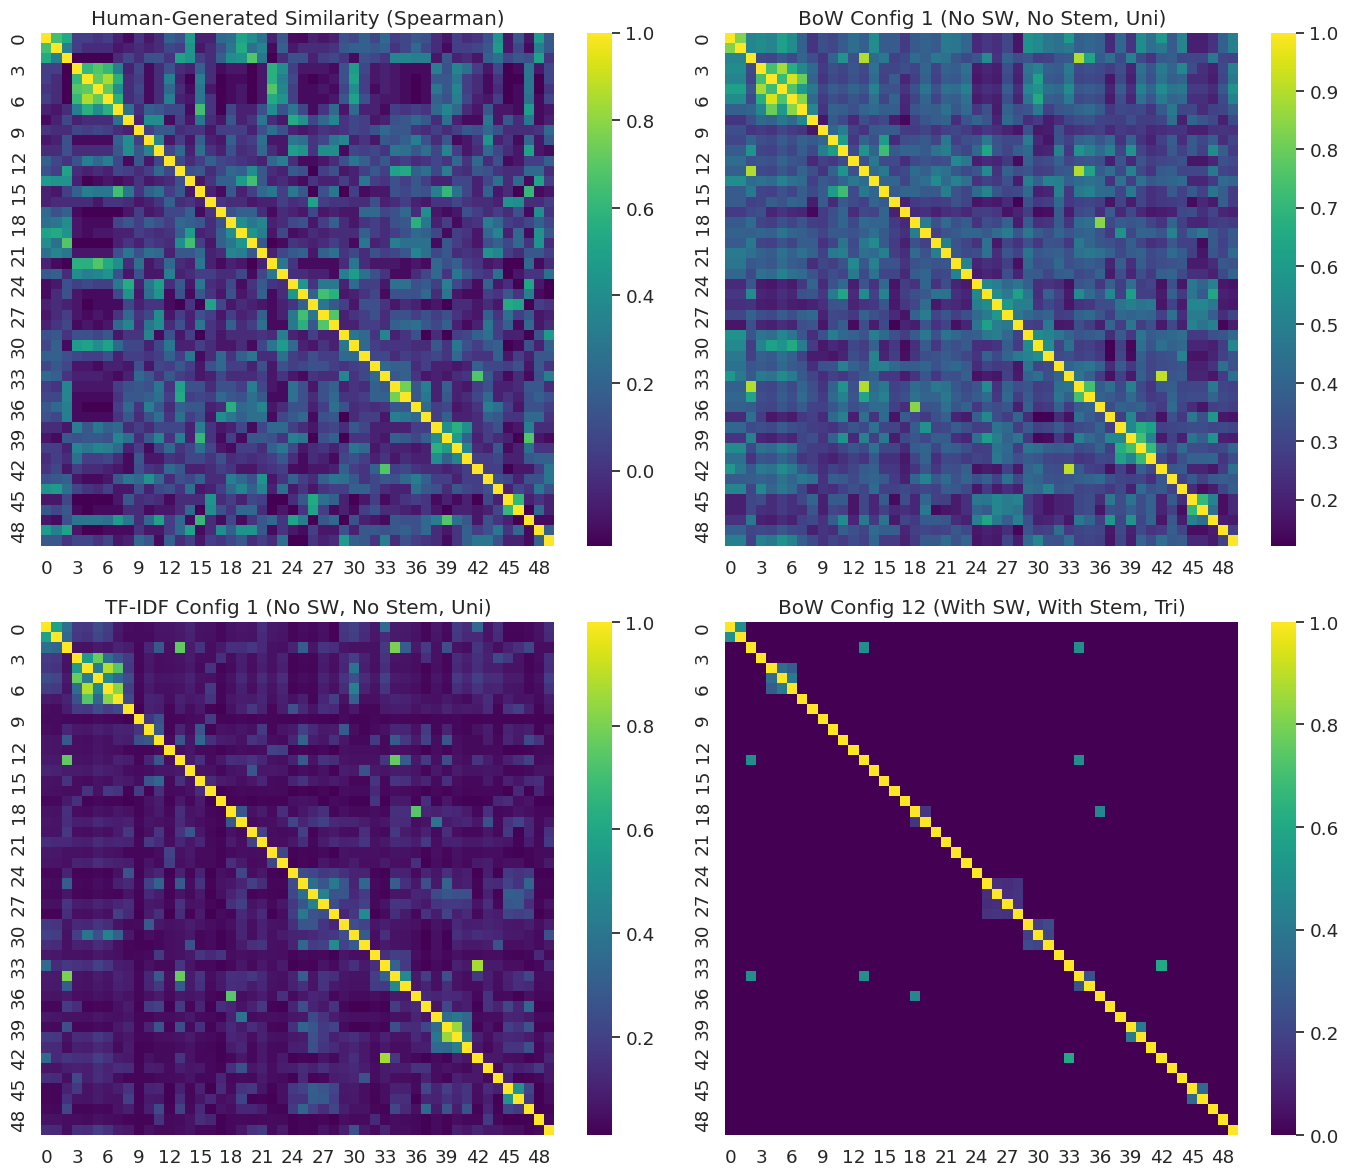

In [21]:
# Visualize a few similarity matrices
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot human similarity matrix
sns.heatmap(human_similarity_matrix, cmap='viridis', ax=axes[0, 0])
axes[0, 0].set_title('Human-Generated Similarity (Spearman)')

# Plot BoW with Config 1 (No stop words, No stemming, Unigrams)
bow_config1 = similarity_matrices[('bow', 1)]
sns.heatmap(bow_config1, cmap='viridis', ax=axes[0, 1])
axes[0, 1].set_title('BoW Config 1 (No SW, No Stem, Uni)')

# Plot TF-IDF with Config 1
tfidf_config1 = similarity_matrices[('tfidf', 1)]
sns.heatmap(tfidf_config1, cmap='viridis', ax=axes[1, 0])
axes[1, 0].set_title('TF-IDF Config 1 (No SW, No Stem, Uni)')

# Plot BoW with Config 12 (With stop words, With stemming, Trigrams)
bow_config12 = similarity_matrices[('bow', 12)]
sns.heatmap(bow_config12, cmap='viridis', ax=axes[1, 1])
axes[1, 1].set_title('BoW Config 12 (With SW, With Stem, Tri)')

plt.tight_layout()
plt.savefig('similarity_matrix_samples.png', dpi=300)
plt.show()

## Save Configuration Information

In [22]:
# Save the configuration information to a CSV file
config_df = pd.DataFrame([
    {'config_id': config_id,
     'stop_words_included': 'Yes' if stop_words else 'No',
     'stemming_applied': 'Yes' if stemming else 'No',
     'ngram_type': ngram}
    for config_id, stop_words, stemming, ngram in configurations
])

config_df.to_csv('/content/drive/MyDrive/NLP 2_2/configurations.csv', index=False)
print("Configuration information saved to configurations.csv")
config_df.head()

Configuration information saved to configurations.csv


,config_id,stop_words_included,stemming_applied,ngram_type
0,1,No,No,uni
1,2,No,No,bi
2,3,No,No,tri
3,4,No,Yes,uni
4,5,No,Yes,bi
